<a href="https://colab.research.google.com/github/xelothi/ML-for-kinase-inhibitors-development/blob/main/CRAF_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chemical origin of CRAF
This is a repository for origin probing of c-RAF(RAF1) kinase using random forest regressor.

In [ ]:
! pip install rdkit

In [ ]:
! pip install padelpy

In [ ]:
! pip install tabulate

In [ ]:
! wget https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
! unzip fingerprints_xml.zip


--2024-03-29 12:12:23--  https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip [following]
--2024-03-29 12:12:23--  https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10871 (11K) [application/zip]
Saving to: ‘fingerprints_xml.zip.3’

fingerprints_xml.zi 100%[===================>]  10.62K  --.-KB/s    in 0s      

2024-03-29 12:12:23 (55.6 MB/s) - ‘fingerprints_xml.zip.3’ saved [10871/10871]

Archive:  fingerprint

In [ ]:
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  from rdkit import Chem, DataStructs
  from rdkit.Chem import Draw, Descriptors, AllChem
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.metrics import r2_score, mean_absolute_error
  from sklearn.model_selection import train_test_split
  from scipy import stats
  from sklearn.ensemble import RandomForestRegressor
  import glob
  import os
  from collections import defaultdict
  from sklearn.model_selection import cross_validate
  from sklearn.model_selection import cross_val_predict
  from collections import defaultdict
  from matplotlib.ticker import MultipleLocator
  import statsmodels.api as sm
  from copy import deepcopy
  from statsmodels.stats.outliers_influence import summary_table
  from tabulate import tabulate
  import pickle

# Importing the data


In [ ]:
df = pd.read_csv("CRAF_train.csv", index_col=[0])
df = df.dropna()
df.rename(columns={"molecule_chembl_id": "Name"}, inplace=True)

In [ ]:
df

,Unnamed: 0,Name,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity
409,409,CHEMBL3938679,Cc1ccc(C(=O)Nc2cccc(C(F)(F)F)c2)cc1-c1cc(N2CCO...,472.467,3.86342,1.0,6.0,4.0,0.416,9.380907,inactive
49,49,CHEMBL69764,Fc1ccc(-c2[nH]c(C3CCNCC3)nc2-c2ccncc2)cc1,322.387,3.74480,2.0,3.0,3.0,80.000,7.096910,inactive
118,118,CHEMBL218932,CNC(=O)Oc1cc(C)c(/C=C/c2cncc(C(=O)NC)c2)c(C)c1,339.395,2.94664,2.0,4.0,4.0,10.000,8.000000,inactive
192,192,CHEMBL472620,Cn1nc(C(C)(C)C)cc1NC(=O)Nc1ccc(Oc2ccncc2)cc1,365.437,4.54890,2.0,5.0,4.0,800.000,6.096910,active
39,39,CHEMBL404842,Clc1ccccc1-c1[nH]c(-c2ccccc2)nc1-c1ccncc1,331.806,5.45910,1.0,2.0,3.0,610.000,6.214670,active
...,...,...,...,...,...,...,...,...,...,...,...
71,71,CHEMBL168186,CCNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Br)c(C(F)(F)F...,523.309,6.04890,3.0,4.0,6.0,27.000,7.568636,inactive
106,106,CHEMBL311402,O=C1Nc2ccc(S(=O)(=O)N(CCO)CCO)cc2C1=Cc1cc(Br)c...,562.236,2.38520,4.0,6.0,7.0,29.000,7.537602,inactive
270,270,CHEMBL3951027,Cc1ccc(NC(=O)c2cccc(C3(C#N)CC3)c2Cl)cc1-c1cc(N...,559.070,4.58610,1.0,8.0,6.0,0.785,9.105130,inactive
435,435,CHEMBL3948871,Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1-c1cc(=O)cc...,457.452,4.45802,2.0,4.0,4.0,1.062,8.973875,inactive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Making fingerprints

return file paths named .xml


In [ ]:
xml_files = glob.glob("*.xml")
xml_files.sort()
xml_files

['AtomPairs2DFingerprintCount.xml',
 'AtomPairs2DFingerprinter.xml',
 'EStateFingerprinter.xml',
 'ExtendedFingerprinter.xml',
 'Fingerprinter.xml',
 'GraphOnlyFingerprinter.xml',
 'KlekotaRothFingerprintCount.xml',
 'KlekotaRothFingerprinter.xml',
 'MACCSFingerprinter.xml',
 'PubchemFingerprinter.xml',
 'SubstructureFingerprintCount.xml',
 'SubstructureFingerprinter.xml']

In [ ]:
#create a list and assign them to the xml files( to compute descriptors)
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [ ]:
fp = dict(zip(FP_list, xml_files)) #create a dictionary of all..
fp

{'AtomPairs2DCount': 'AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'AtomPairs2DFingerprinter.xml',
 'EState': 'EStateFingerprinter.xml',
 'CDKextended': 'ExtendedFingerprinter.xml',
 'CDK': 'Fingerprinter.xml',
 'CDKgraphonly': 'GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'KlekotaRothFingerprinter.xml',
 'MACCS': 'MACCSFingerprinter.xml',
 'PubChem': 'PubchemFingerprinter.xml',
 'SubstructureCount': 'SubstructureFingerprintCount.xml',
 'Substructure': 'SubstructureFingerprinter.xml'}

In [ ]:
selection = ["Name", "std_smiles"]
df2 = df[selection]
df2

,Name,std_smiles
409,CHEMBL3938679,Cc1ccc(C(=O)Nc2cccc(C(F)(F)F)c2)cc1-c1cc(N2CCO...
49,CHEMBL69764,Fc1ccc(-c2[nH]c(C3CCNCC3)nc2-c2ccncc2)cc1
118,CHEMBL218932,CNC(=O)Oc1cc(C)c(/C=C/c2cncc(C(=O)NC)c2)c(C)c1
192,CHEMBL472620,Cn1nc(C(C)(C)C)cc1NC(=O)Nc1ccc(Oc2ccncc2)cc1
39,CHEMBL404842,Clc1ccccc1-c1[nH]c(-c2ccccc2)nc1-c1ccncc1
...,...,...
71,CHEMBL168186,CCNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Br)c(C(F)(F)F...
106,CHEMBL311402,O=C1Nc2ccc(S(=O)(=O)N(CCO)CCO)cc2C1=Cc1cc(Br)c...
270,CHEMBL3951027,Cc1ccc(NC(=O)c2cccc(C3(C#N)CC3)c2Cl)cc1-c1cc(N...
435,CHEMBL3948871,Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1-c1cc(=O)cc...


In [ ]:
df2 = pd.concat( [df['std_smiles'],df['Name']], axis=1 )
df2.to_csv('molecule.smi', sep='\t', index=False, header=False)
df2

,std_smiles,Name
409,Cc1ccc(C(=O)Nc2cccc(C(F)(F)F)c2)cc1-c1cc(N2CCO...,CHEMBL3938679
49,Fc1ccc(-c2[nH]c(C3CCNCC3)nc2-c2ccncc2)cc1,CHEMBL69764
118,CNC(=O)Oc1cc(C)c(/C=C/c2cncc(C(=O)NC)c2)c(C)c1,CHEMBL218932
192,Cn1nc(C(C)(C)C)cc1NC(=O)Nc1ccc(Oc2ccncc2)cc1,CHEMBL472620
39,Clc1ccccc1-c1[nH]c(-c2ccccc2)nc1-c1ccncc1,CHEMBL404842
...,...,...
71,CCNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Br)c(C(F)(F)F...,CHEMBL168186
106,O=C1Nc2ccc(S(=O)(=O)N(CCO)CCO)cc2C1=Cc1cc(Br)c...,CHEMBL311402
270,Cc1ccc(NC(=O)c2cccc(C3(C#N)CC3)c2Cl)cc1-c1cc(N...,CHEMBL3951027
435,Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1-c1cc(=O)cc...,CHEMBL3948871


Calculating the 12 fingerprint descriptors from padelpy

In [ ]:
from padelpy import padeldescriptor

for key in fp.keys():
    fingerprint_output_file = f'{key}.csv' #Substructure.csv
    fingerprint_descriptortypes = fp[key]
    padeldescriptor(mol_dir='molecule.smi',
                    d_file=fingerprint_output_file, #'Substructure.csv'
                    #descriptortypes='SubstructureFingerprint.xml',
                    descriptortypes= fingerprint_descriptortypes,
                    detectaromaticity=True,
                    standardizenitro=True,
                    standardizetautomers=True,
                    threads=4,
                    removesalt=True,
                    log=True,
                    fingerprints=True)

descriptor = pd.DataFrame(eval(fingerprint_output_file))
output = descriptor.to_csv(f"{descriptor}_output_file.csv")

Storing fingerprints inside of CSV files

In [ ]:
AtomPairs2D = pd.read_csv("AtomPairs2D.csv", header=0)
AtomPairs2DCount = pd.read_csv("AtomPairs2DCount.csv", header=0)
CDK = pd.read_csv("CDK.csv", header=0)
CDKextended = pd.read_csv("CDKextended.csv", header=0)
CDKgraphonly = pd.read_csv("CDKgraphonly.csv", header=0)
EState = pd.read_csv("EState.csv", header=0)
KlekotaRoth = pd.read_csv("KlekotaRoth.csv", header=0)
KlekotaRothCount = pd.read_csv("KlekotaRothCount.csv", header=0)
PubChem = pd.read_csv("PubChem.csv", header=0)
MACCS = pd.read_csv("MACCS.csv", header=0)
SubstructureCount = pd.read_csv("SubstructureCount.csv", header=0)
Substructure = pd.read_csv("Substructure.csv", header=0)

# Feature engineering

Selecting

In [ ]:
def normalized(Fp):
    Name = Fp['Name']
    Fp_ix = Fp.iloc[:, 1:]
    min_max_scaler = MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(Fp_ix)
    Fp_normalized = pd.DataFrame(np_scaled, columns=Fp_ix.columns)
    Fp_normalized['Name'] = Name

    return Fp_normalized


In [ ]:
atom_pairs_2D_norm = normalized(AtomPairs2D)
atom_pairs_2D_count_norm = normalized(AtomPairs2DCount)
CDK_norm = normalized(CDK)
CDK_extended_norm = normalized(CDKextended)
CDK_graphonly_norm = normalized(CDKgraphonly)
EState_norm = normalized(EState)
Klekota_roth_norm = normalized(KlekotaRoth)
Klekota_roth_count_norm = normalized(KlekotaRothCount)
PubChem_norm = normalized(PubChem)
substrucutre_norm = normalized(Substructure)
substrucutre_count_norm = normalized(SubstructureCount)
MACCS_norm = normalized(MACCS)


In [ ]:
atom_pairs_2D_norm.to_csv("/content/gdrive/MyDrive/CRAF_hand_picked/AtomPairs2D_normalized.csv", sep=',' ,index=False)
atom_pairs_2D_count_norm.to_csv("/content/gdrive/MyDrive/CRAF_hand_picked/AtomPairs2DCount_normalized.csv", sep=',' ,index=False)
CDK_norm.to_csv("/content/gdrive/MyDrive/CRAF_hand_picked/CDK_normalized.csv", sep=",", index=False)
CDK_extended_norm.to_csv("/content/gdrive/MyDrive/CRAF_hand_picked/CDKextened_normalized.csv", sep=",", index=False)
CDK_graphonly_norm.to_csv("/content/gdrive/MyDrive/CRAF_hand_picked/CDK_graphonly_normalized.csv", sep=",", index=False)
EState_norm.to_csv("/content/gdrive/MyDrive/CRAF_hand_picked/EState_normalized.csv", sep=",", index=False)
Klekota_roth_norm.to_csv("/content/gdrive/MyDrive/CRAF_hand_picked/KlekotaRoth_nomralized.csv", sep=",", index=False)
Klekota_roth_count_norm.to_csv("/content/gdrive/MyDrive/CRAF_hand_picked/KlekotaRothCount_normalized.csv", sep=",", index=False)
PubChem_norm.to_csv("/content/gdrive/MyDrive/CRAF_hand_picked/PubChem_normalized.csv", sep=",", index=False)
substrucutre_norm.to_csv("/content/gdrive/MyDrive/CRAF_hand_picked/Substructure_normalized.csv", sep=",", index=False)
substrucutre_count_norm.to_csv("/content/gdrive/MyDrive/CRAF_hand_picked/SubstrucutreCount_normalized.csv", sep=",", index=False)
MACCS_norm.to_csv("/content/gdrive/MyDrive/CRAF_hand_picked/MACCS_normalized.csv", sep=",", index=False)


This function is used to preprocess feature data by removing descriptors that exhibit low variability (low standard deviation) and are considered less informative

In [ ]:
def remove_useless_descriptors(input_df, stdev_threshold):
    initial_descriptor_count = len(input_df.columns)

    descriptor_names = input_df.columns.tolist()
    data_values = input_df.values.astype(float)
    descriptor_matrix = np.array(data_values)

    standard_deviations = np.std(descriptor_matrix, axis=0)
    indices_to_keep = [idx for idx, std_dev in enumerate(standard_deviations) if std_dev > stdev_threshold]
    new_descriptor_matrix = descriptor_matrix[:, indices_to_keep]
    remaining_descriptor_names = np.array(descriptor_names)[indices_to_keep]

    new_df = pd.DataFrame(new_descriptor_matrix, columns=[remaining_descriptor_names])

    final_descriptor_count = len(new_df.columns)

    print('Removing useless descriptors')
    print('-------------------------------------------------------------------------')
    print(f'The initial set of {initial_descriptor_count} descriptors has been reduced to {final_descriptor_count} descriptors.')

    return new_df


 this function is used to preprocess feature data by identifying and removing descriptors that exhibit high linear Pearson correlation with other descriptors.

In [ ]:
def remove_highly_correlated_descriptors(data, correlation_threshold):

    initial_descriptor_count = len(data.columns)
    correlation_function = stats.pearsonr
    correlated_column_names = set()

    correlation_matrix = data.corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if correlation_matrix.iloc[i, j] >= correlation_threshold:
                column_name = correlation_matrix.columns[i]  # Getting the name of the column
                correlated_column_names.add(column_name)
                if column_name in data.columns:
                    del data[column_name]  # Deleting the column from the dataset

    final_descriptor_count = len(data.columns)

    print('Removing highly correlated descriptors')
    print('-------------------------------------------------------------------------')
    print(f'The initial set of {initial_descriptor_count} descriptors has been reduced to {final_descriptor_count} descriptors.')

    return data

#Y scrambling
We conduct Y_scrambling to ensure that the results produced by our machine learning model arent produect by chance

In [ ]:

def perform_y_scrambling(X_train, X_test, y_train, y_test):

    for random_seed_counter in range(1, 101):
        # Create shuffled copies of the training labels and features
        y_train_shuffled = deepcopy(y_train)

        np.random.shuffle(y_train_shuffled)

        # Train a RandomForestRegressor on the shuffled data
        rf_scrambled = RandomForestRegressor()
        rf_scrambled = rf_scrambled.fit(X_train, y_train_shuffled)

        # Predictions on the test set
        y_predict_test = rf_scrambled.predict(X_test)
        r2_test_scramble = (rf_scrambled.score(X_test, y_test))**2
        r2_scores_test_scrambled.append(r2_test_scramble)

        # Predictions on the train set
        y_predict_train = rf_scrambled.predict(X_train)
        r2_train_scramble =  (rf_scrambled.score(X_train, y_train))**2
        r2_scores_train_scrambled.append(r2_train_scramble)

    return r2_scores_test_scrambled, r2_scores_train_scrambled

In [ ]:
def metrics(R2_train, RMSE_train, Q2_CV, RMSE_CV, Q2_External, RMSE_External, importances_dict):
    R2_train_mean = np.mean(R2_train)
    RMSE_train_mean = np.mean(RMSE_train)
    Q2_CV_mean = np.mean(Q2_CV)




    RMSE_CV_mean = np.mean(RMSE_CV)
    Q2_External_mean = np.mean(Q2_External)
    RMSE_External_mean = np.mean(RMSE_External)

    R2_train_std = np.std(R2_train)
    RMSE_train_std = np.std(RMSE_train)
    Q2_CV_std = np.std(Q2_CV)
    RMSE_CV_std = np.std(RMSE_CV)
    Q2_External_std = np.std(Q2_External)
    RMSE_External_std = np.std(RMSE_External)


    importances_mean0 = {}
    for fx in importances_dict:
        importances_mean0[fx] = np.mean(importances_dict[fx])
    importances_mean = sorted([(k,v) for k,v in importances_mean0.items()],
                                     key=lambda x: x[1], reverse=True)

    importances_std0 = {}
    for fx in importances_dict:
        importances_std0[fx] = np.std(importances_dict[fx])
    importances_std = sorted([(k,v) for k,v in importances_std0.items()],
                                     key=lambda x: x[1], reverse=True)


    return R2_train_mean, RMSE_train_mean, Q2_CV_mean, RMSE_CV_mean, Q2_External_mean, RMSE_External_mean, R2_train_std, RMSE_train_std, Q2_CV_std, RMSE_CV_std, Q2_External_std, RMSE_External_std, importances_mean, importances_std

In [ ]:
path =  "/content/gdrive/MyDrive/CRAF_hand_picked/"

In [ ]:
def extract_file_name(file_path):
    # Extract the file name without extension
    file_name = os.path.basename(file_path)
    file_name_without_extension = os.path.splitext(file_name)[0]
    return file_name_without_extension

# Calculating model performance

In [ ]:
def model_performance(y_train,y_test, prediction, cv, prediction_external):
    R2_train.append(r2_score(y_train, prediction))
    RMSE_train.append(np.sqrt(mean_absolute_error(y_train, prediction)))
    Q2_cross_val.append(r2_score(y_train, cv))
    RMSE_cross_val.append(np.sqrt(mean_absolute_error(y_train, cv)))
    Q2_ext.append(r2_score(y_test, prediction_external))
    RMSE_ext.append((mean_absolute_error(y_test, prediction_external)))


# Model

In [ ]:
def model_training_and_validation(X,Y,seed, hx, verbose=True):


    #Data split using 70/30 ratio
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        Y, test_size=0.3,
                                                        random_state=seed)
    param = {
        'max_depth': 20,
        'max_features': 'sqrt',
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 200,
        "n_jobs": -1
    }
    model_RF = RandomForestRegressor(random_state=SEED, **param)

    model_RF.fit(X_train,y_train)
    prediction = model_RF.predict(X_train)

    # Cross-validation
    cv = cross_val_predict(model_RF, X_train, y_train, cv=10, n_jobs=-1)

    # External set
    prediction_external = model_RF.predict(X_test)

    #print result from each seed
    model_performance(y_train,y_test, prediction, cv, prediction_external)

    #Feature Importance
    Feature = hx[:]
    feature_importance = model_RF.feature_importances_
    importances = 100.0 * (feature_importance / feature_importance.max()) #index

    for i, fx in enumerate(Feature):
        importances_dict[str(fx)].append(importances[i])

    pickle.dump(model_RF, open(f'{model_name}.pkl_', 'wb'))
    return Feature, X_train, X_test, y_train, y_test, importances_dict

In [ ]:
def plot_model(fp_file, X_train, X_test, y_train, y_test,
              R2_train_mean, Q2_External_mean,
              importances_mean, importances_std, Feature, prediction_train,
              r2_scores_test_scrambled, r2_scores_train_scrambled):

    # Set figure size
    ml_model = RandomForestRegressor()
    model = ml_model.fit(X_train, y_train)

    plt.figure(figsize=(10, 10))
    cm = plt.cm.RdBu
    cv =  cross_val_predict(ml_model, X_train, y_train, cv=10, n_jobs=-1)
    # Train Set
    y_train_pred = model.predict(X_train).flatten()
    plt.scatter(y_train, y_train_pred, s=50, marker='.', alpha=0.3,
                c='purple', edgecolors='purple', label=f"$R^2_{{Tr}}$ = {R2_train_mean:.4f}")

    # CV Set
    y_cv_pred = cv
    plt.scatter(y_train, y_cv_pred, s=50, marker='.', alpha=0.3,
                c='orange', edgecolors='orange', label=f"$Q^2_{{Ext}}$ = {Q2_External_mean:.4f}")

    # 2SD line
    X = sm.add_constant(y_train)
    res = sm.OLS(y_cv_pred, X).fit()
    st, data, ss2 = summary_table(res, alpha=0.05)
    predict_ci_low, predict_ci_upp = data[:, 6:8].T
    plt.plot(y_train, predict_ci_low, '--b', linewidth=0.5, alpha=0.5)
    plt.plot(y_train, predict_ci_upp, '--b', linewidth=0.5, alpha=0.5)

    # External Set
    y_external_pred = ml_model.predict(X_test).flatten()
    plt.scatter(y_test, y_external_pred, s=50, marker='.', alpha=0.3,
                c='green', edgecolors='green', label=f"$Q^2_{{Ext}}$ = {Q2_External_mean:.4f}")

    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.legend(loc=2, prop={'size': 6})

    min_axis = np.min(np.concatenate([y_train, y_train_pred, y_external_pred], axis=0))
    max_axis = np.max(np.concatenate([y_train, y_train_pred, y_external_pred], axis=0))
    plt.xlim([(min_axis * 0.9), (max_axis * 1.05)])
    plt.ylim([(min_axis * 0.9), (max_axis * 1.05)])
    plt.tick_params(axis='both', which='major', labelsize=14)

    # Save plot to file
    plt.savefig(f'{fp_file}_compair_Fp.pdf', dpi=300)
    plt.show()

    # Y-scrambling plot
    plt.figure(figsize=(5, 5))
    plt.scatter(Q2_CV_mean, R2_train_mean, s=100, marker='.', alpha=0.3,
                c='blue',edgecolors='blue', label="$Q^{2}$ vs. $R^{2}$ (CV)")

    plt.scatter(r2_scores_test_scrambled, r2_scores_train_scrambled,
                s=100, marker='.', alpha=0.3, c='violet',  edgecolors='red',
                label="Y-scrambling")

    plt.xlabel("$Q^{2}$", fontsize=10)
    plt.ylabel("$R^{2}$", fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.axhline(0.5, color='gray', linestyle='--', dashes=(5, 10), linewidth=0.5)
    plt.axvline(0.5, color='gray', linestyle='--', dashes=(5, 10), linewidth=0.5)
    plt.legend(loc=2, prop={'size': 6})
    plt.savefig(f'{fp_file}_Y_scrambling.pdf', dpi=300)
    plt.show()

    # Feature Importance
    plt.figure(figsize=(5, 10))
    barlist = plt.barh(range(20), [x[1] for x in importances_mean[:20]],
                      color="cyan", xerr=[x[1] for x in importances_std[:20]], align="center",
                      error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

    print("top10", [x[0] for x in importances_mean[:10]])
    print("top20", [x[0] for x in importances_mean[:20]])
    print("top30", [x[0] for x in importances_mean[:30]])
    print("top40", [x[0] for x in importances_mean[:40]])
    print("top50", [x[0] for x in importances_mean[:50]])

    plt.yticks(range(20), [x[0] for x in importances_mean[:20]])
    plt.ylim([-1, 20])
    plt.xlabel("Gini Index", fontsize=12)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.tight_layout(pad=2.0, w_pad=0.7, h_pad=2.0)
    plt.savefig(f'{fp_file}_Feature_importances.pdf', dpi=300)
    plt.show()


----------------------------------------------------------------------------------------------
CDK_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 1024 descriptors has been reduced to 1019 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 1019 descriptors has been reduced to 895 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 413      |
+----------------------+----------+
| R2                   | 0.9688   |
+----------------------+----------+
| std_R2               | 0.001333 |
+----------------------+----------+
| RMSE                 | 0.4265   |
+----------------------+----------+
| std_R

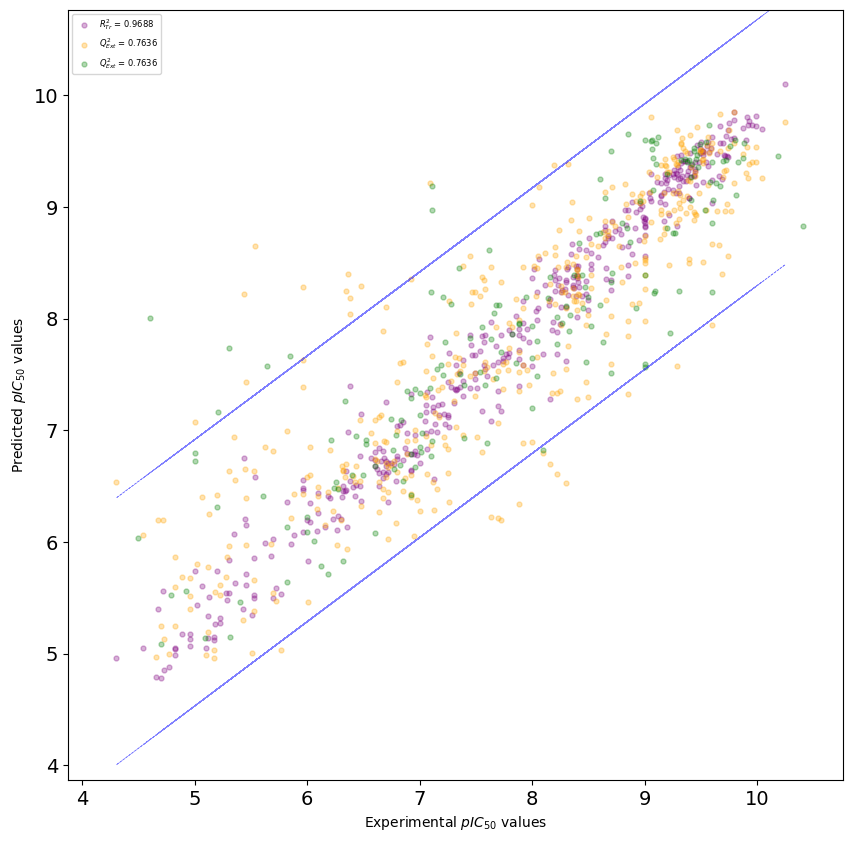

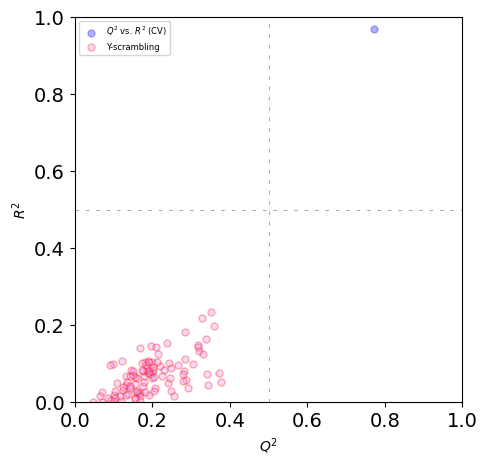

top10 ["['FP408']", "['FP389']", "['FP293']", "['FP382']", "['FP637']", "['FP359']", "['FP1005']", "['FP317']", "['FP966']", "['FP195']"]
top20 ["['FP408']", "['FP389']", "['FP293']", "['FP382']", "['FP637']", "['FP359']", "['FP1005']", "['FP317']", "['FP966']", "['FP195']", "['FP744']", "['FP909']", "['FP648']", "['FP954']", "['FP626']", "['FP337']", "['FP512']", "['FP514']", "['FP836']", "['FP609']"]
top30 ["['FP408']", "['FP389']", "['FP293']", "['FP382']", "['FP637']", "['FP359']", "['FP1005']", "['FP317']", "['FP966']", "['FP195']", "['FP744']", "['FP909']", "['FP648']", "['FP954']", "['FP626']", "['FP337']", "['FP512']", "['FP514']", "['FP836']", "['FP609']", "['FP754']", "['FP392']", "['FP547']", "['FP56']", "['FP321']", "['FP72']", "['FP872']", "['FP264']", "['FP969']", "['FP774']"]
top40 ["['FP408']", "['FP389']", "['FP293']", "['FP382']", "['FP637']", "['FP359']", "['FP1005']", "['FP317']", "['FP966']", "['FP195']", "['FP744']", "['FP909']", "['FP648']", "['FP954']", "['FP626

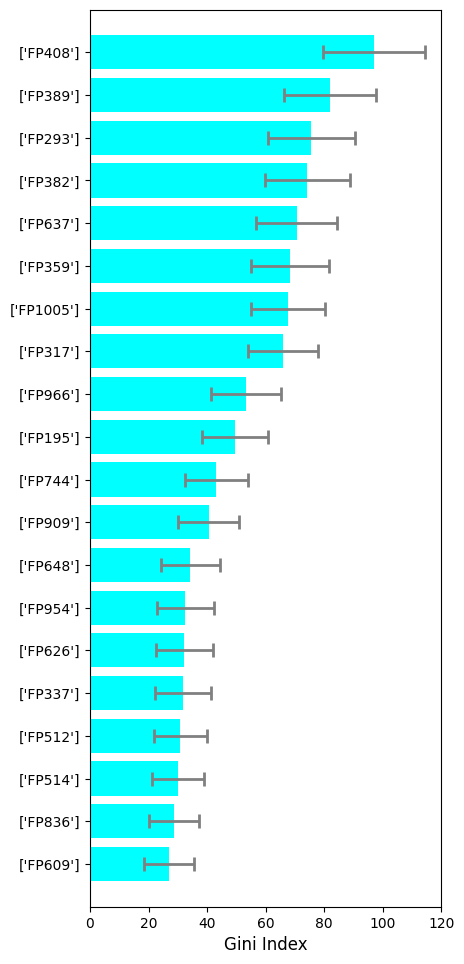

----------------------------------------------------------------------------------------------
EState_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 79 descriptors has been reduced to 28 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 28 descriptors has been reduced to 26 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 413      |
+----------------------+----------+
| R2                   | 0.9014   |
+----------------------+----------+
| std_R2               | 0.007052 |
+----------------------+----------+
| RMSE                 | 0.5701   |
+----------------------+----------+
| std_RMSE 

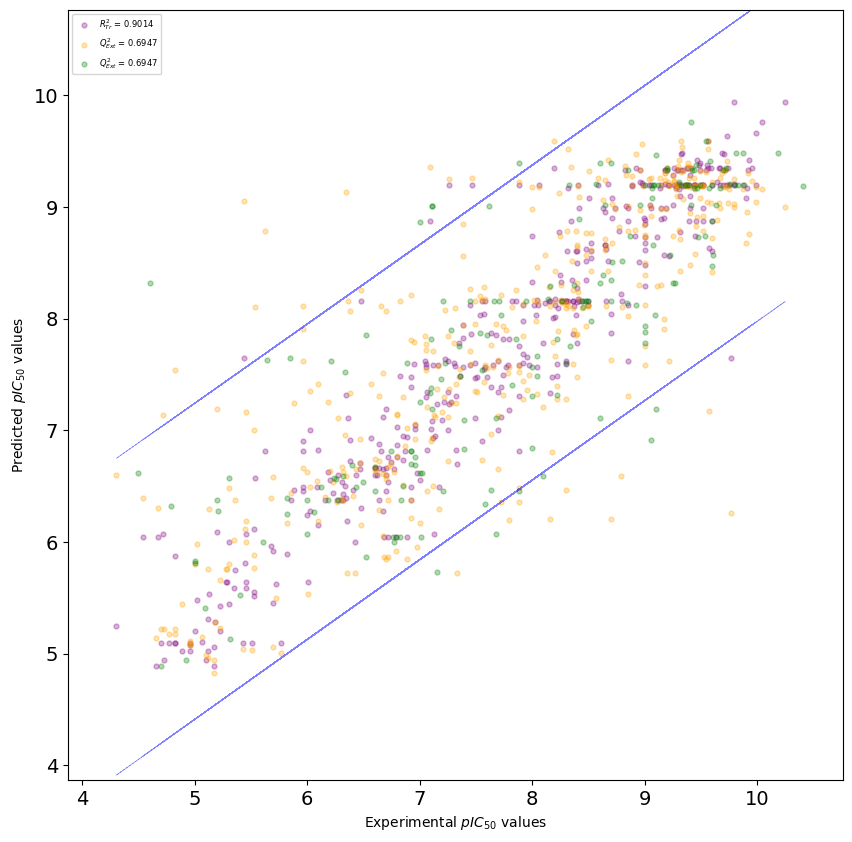

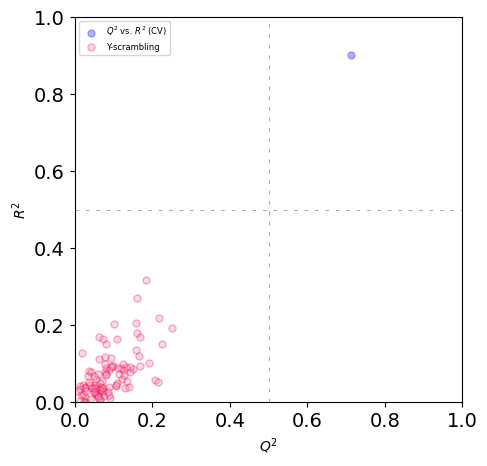

top10 ["['EStateFP30']", "['EStateFP28']", "['EStateFP9']", "['EStateFP18']", "['EStateFP38']", "['EStateFP51']", "['EStateFP36']", "['EStateFP19']", "['EStateFP11']", "['EStateFP35']"]
top20 ["['EStateFP30']", "['EStateFP28']", "['EStateFP9']", "['EStateFP18']", "['EStateFP38']", "['EStateFP51']", "['EStateFP36']", "['EStateFP19']", "['EStateFP11']", "['EStateFP35']", "['EStateFP25']", "['EStateFP54']", "['EStateFP13']", "['EStateFP29']", "['EStateFP7']", "['EStateFP16']", "['EStateFP53']", "['EStateFP32']", "['EStateFP24']", "['EStateFP37']"]
top30 ["['EStateFP30']", "['EStateFP28']", "['EStateFP9']", "['EStateFP18']", "['EStateFP38']", "['EStateFP51']", "['EStateFP36']", "['EStateFP19']", "['EStateFP11']", "['EStateFP35']", "['EStateFP25']", "['EStateFP54']", "['EStateFP13']", "['EStateFP29']", "['EStateFP7']", "['EStateFP16']", "['EStateFP53']", "['EStateFP32']", "['EStateFP24']", "['EStateFP37']", "['EStateFP21']", "['EStateFP70']", "['EStateFP15']", "['EStateFP17']", "['EStateFP8

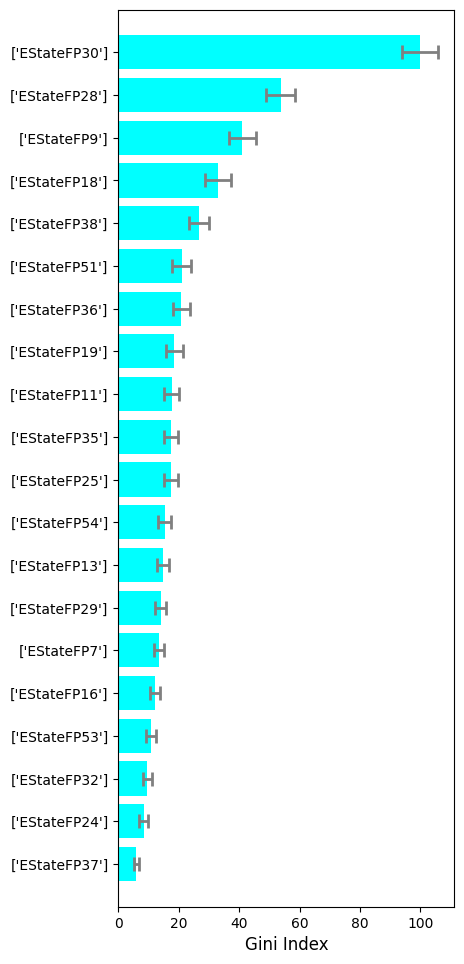

----------------------------------------------------------------------------------------------
AtomPairs2D_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 780 descriptors has been reduced to 230 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 230 descriptors has been reduced to 99 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 413      |
+----------------------+----------+
| R2                   | 0.9428   |
+----------------------+----------+
| std_R2               | 0.005447 |
+----------------------+----------+
| RMSE                 | 0.4978   |
+----------------------+----------+
| s

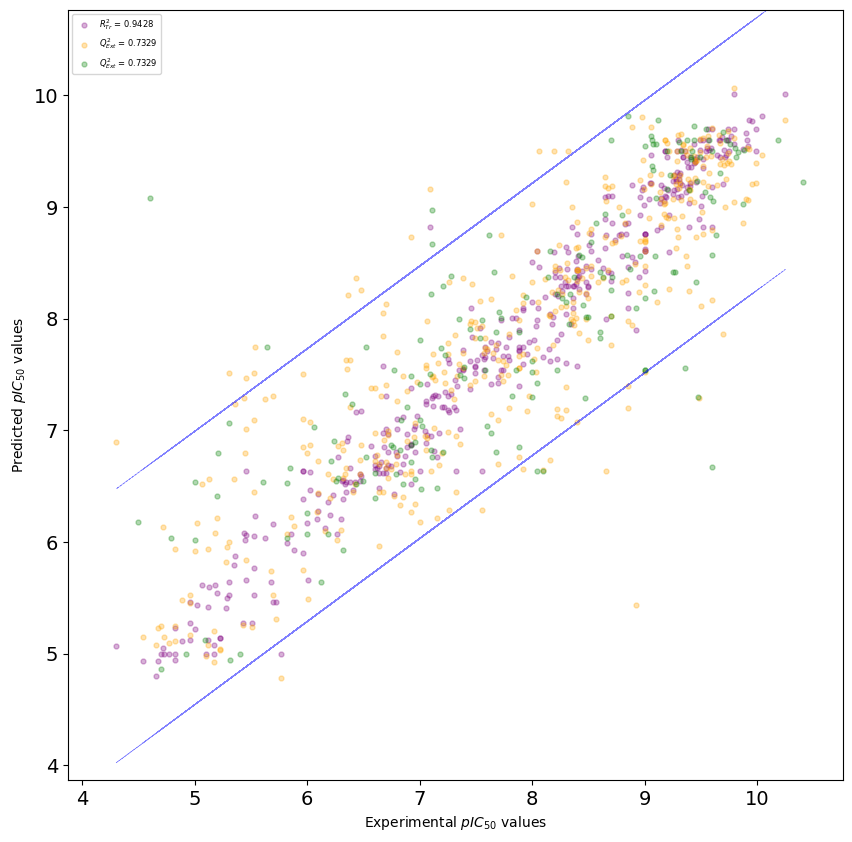

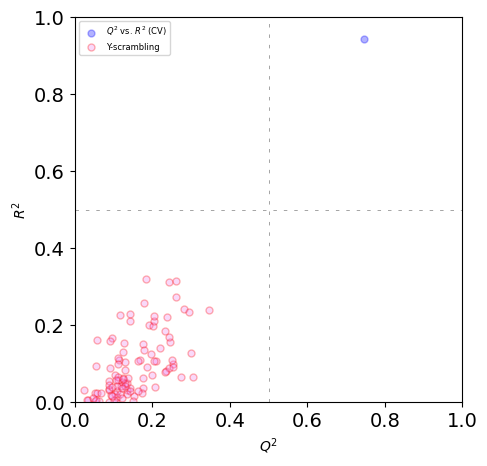

top10 ["['AD2D481']", "['AD2D170']", "['AD2D407']", "['AD2D638']", "['AD2D716']", "['AD2D336']", "['AD2D726']", "['AD2D6']", "['AD2D171']", "['AD2D637']"]
top20 ["['AD2D481']", "['AD2D170']", "['AD2D407']", "['AD2D638']", "['AD2D716']", "['AD2D336']", "['AD2D726']", "['AD2D6']", "['AD2D171']", "['AD2D637']", "['AD2D715']", "['AD2D482']", "['AD2D492']", "['AD2D248']", "['AD2D485']", "['AD2D559']", "['AD2D414']", "['AD2D404']", "['AD2D329']", "['AD2D337']"]
top30 ["['AD2D481']", "['AD2D170']", "['AD2D407']", "['AD2D638']", "['AD2D716']", "['AD2D336']", "['AD2D726']", "['AD2D6']", "['AD2D171']", "['AD2D637']", "['AD2D715']", "['AD2D482']", "['AD2D492']", "['AD2D248']", "['AD2D485']", "['AD2D559']", "['AD2D414']", "['AD2D404']", "['AD2D329']", "['AD2D337']", "['AD2D325']", "['AD2D14']", "['AD2D91']", "['AD2D247']", "['AD2D560']", "['AD2D81']", "['AD2D571']", "['AD2D13']", "['AD2D403']", "['AD2D169']"]
top40 ["['AD2D481']", "['AD2D170']", "['AD2D407']", "['AD2D638']", "['AD2D716']", "['AD2D

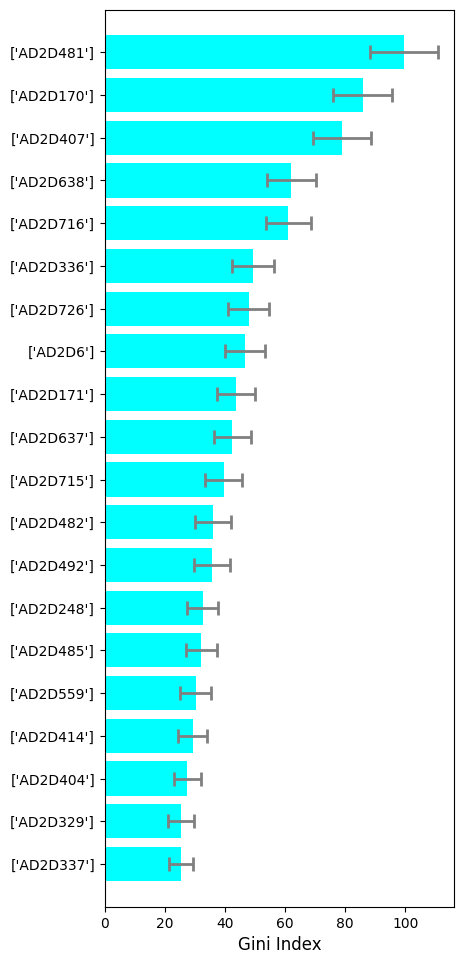

----------------------------------------------------------------------------------------------
AtomPairs2DCount_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 780 descriptors has been reduced to 241 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 241 descriptors has been reduced to 97 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 413      |
+----------------------+----------+
| R2                   | 0.9676   |
+----------------------+----------+
| std_R2               | 0.002037 |
+----------------------+----------+
| RMSE                 | 0.4361   |
+----------------------+----------

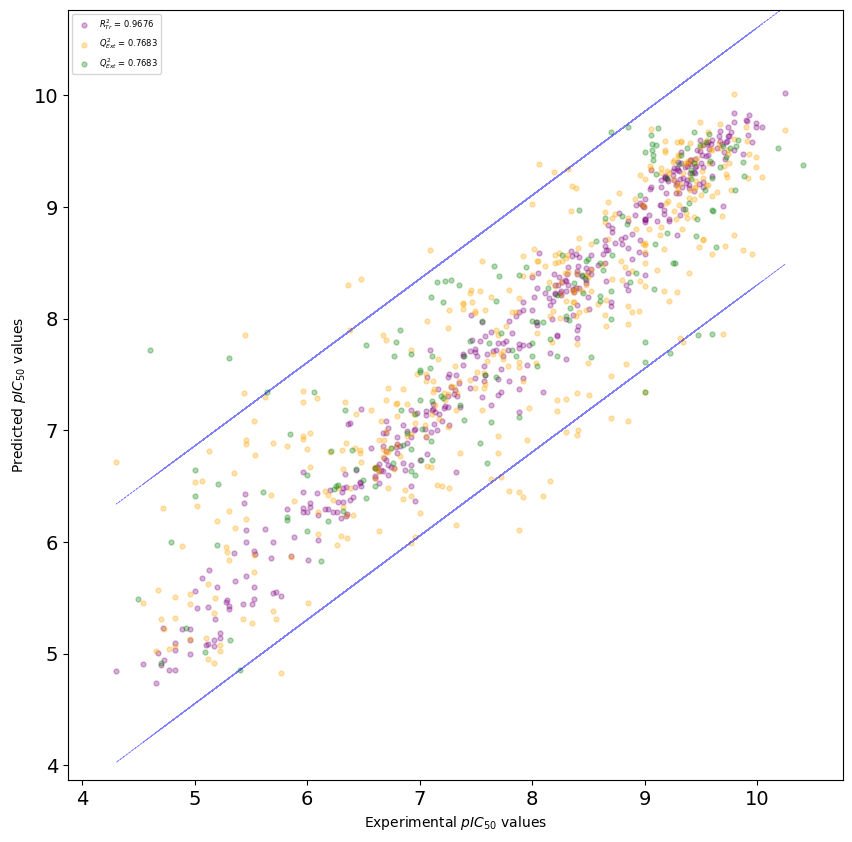

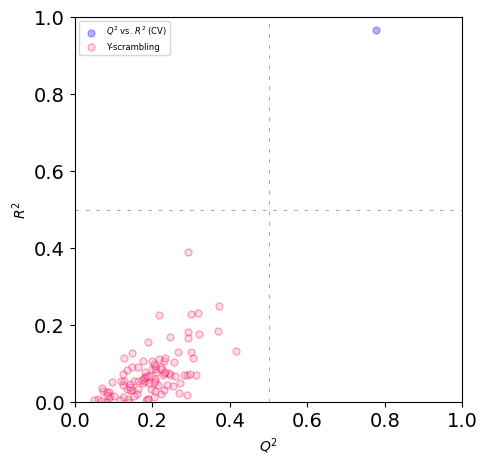

top10 ["['APC2D1_C_C']", "['APC2D9_C_N']", "['APC2D1_C_N']", "['APC2D8_C_O']", "['APC2D3_N_O']", "['APC2D9_N_O']", "['APC2D1_C_O']", "['APC2D2_N_O']", "['APC2D10_N_O']", "['APC2D7_C_N']"]
top20 ["['APC2D1_C_C']", "['APC2D9_C_N']", "['APC2D1_C_N']", "['APC2D8_C_O']", "['APC2D3_N_O']", "['APC2D9_N_O']", "['APC2D1_C_O']", "['APC2D2_N_O']", "['APC2D10_N_O']", "['APC2D7_C_N']", "['APC2D1_C_F']", "['APC2D2_N_N']", "['APC2D4_N_O']", "['APC2D10_N_N']", "['APC2D3_O_S']", "['APC2D9_N_N']", "['APC2D10_O_O']", "['APC2D5_O_O']", "['APC2D7_N_O']", "['APC2D6_O_O']"]
top30 ["['APC2D1_C_C']", "['APC2D9_C_N']", "['APC2D1_C_N']", "['APC2D8_C_O']", "['APC2D3_N_O']", "['APC2D9_N_O']", "['APC2D1_C_O']", "['APC2D2_N_O']", "['APC2D10_N_O']", "['APC2D7_C_N']", "['APC2D1_C_F']", "['APC2D2_N_N']", "['APC2D4_N_O']", "['APC2D10_N_N']", "['APC2D3_O_S']", "['APC2D9_N_N']", "['APC2D10_O_O']", "['APC2D5_O_O']", "['APC2D7_N_O']", "['APC2D6_O_O']", "['APC2D6_N_O']", "['APC2D5_N_O']", "['APC2D5_N_N']", "['APC2D8_N_O']", 

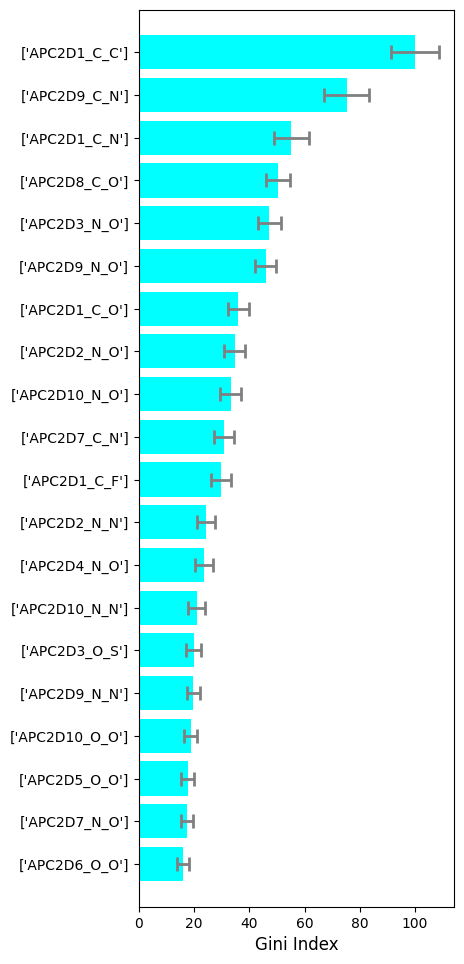

----------------------------------------------------------------------------------------------
CDK_graphonly_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 1024 descriptors has been reduced to 898 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 898 descriptors has been reduced to 399 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 413      |
+----------------------+----------+
| R2                   | 0.9632   |
+----------------------+----------+
| std_R2               | 0.002698 |
+----------------------+----------+
| RMSE                 | 0.4398   |
+----------------------+----------+

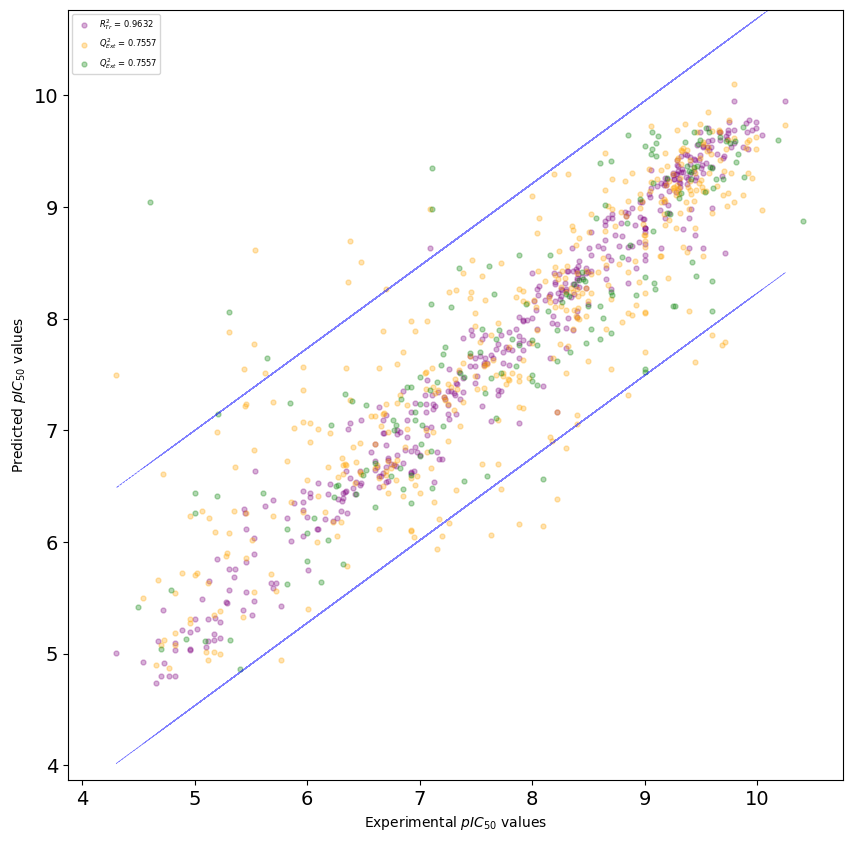

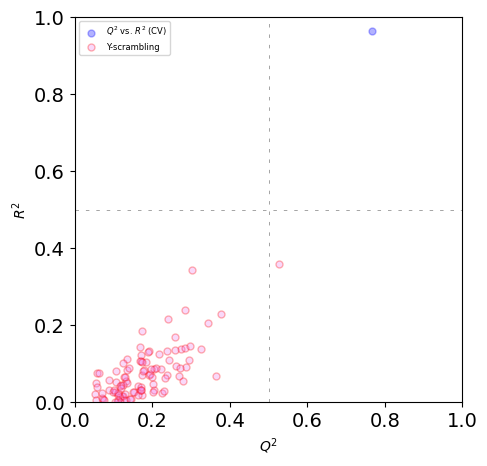

top10 ["['GraphFP837']", "['GraphFP232']", "['GraphFP200']", "['GraphFP591']", "['GraphFP251']", "['GraphFP253']", "['GraphFP144']", "['GraphFP695']", "['GraphFP21']", "['GraphFP204']"]
top20 ["['GraphFP837']", "['GraphFP232']", "['GraphFP200']", "['GraphFP591']", "['GraphFP251']", "['GraphFP253']", "['GraphFP144']", "['GraphFP695']", "['GraphFP21']", "['GraphFP204']", "['GraphFP481']", "['GraphFP564']", "['GraphFP575']", "['GraphFP96']", "['GraphFP910']", "['GraphFP780']", "['GraphFP277']", "['GraphFP118']", "['GraphFP523']", "['GraphFP250']"]
top30 ["['GraphFP837']", "['GraphFP232']", "['GraphFP200']", "['GraphFP591']", "['GraphFP251']", "['GraphFP253']", "['GraphFP144']", "['GraphFP695']", "['GraphFP21']", "['GraphFP204']", "['GraphFP481']", "['GraphFP564']", "['GraphFP575']", "['GraphFP96']", "['GraphFP910']", "['GraphFP780']", "['GraphFP277']", "['GraphFP118']", "['GraphFP523']", "['GraphFP250']", "['GraphFP551']", "['GraphFP522']", "['GraphFP135']", "['GraphFP833']", "['GraphFP90

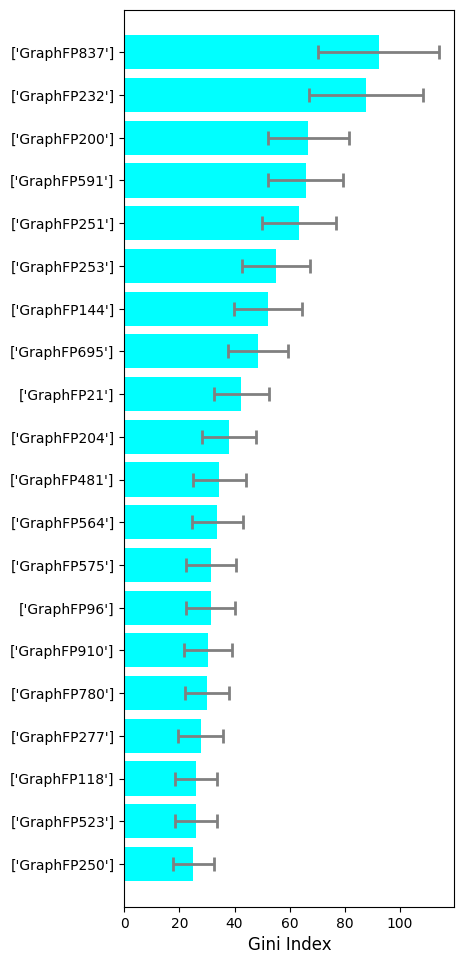

----------------------------------------------------------------------------------------------
CDKextened_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 1024 descriptors has been reduced to 997 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 997 descriptors has been reduced to 888 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 413      |
+----------------------+----------+
| R2                   | 0.9684   |
+----------------------+----------+
| std_R2               | 0.001972 |
+----------------------+----------+
| RMSE                 | 0.4282   |
+----------------------+----------+
| 

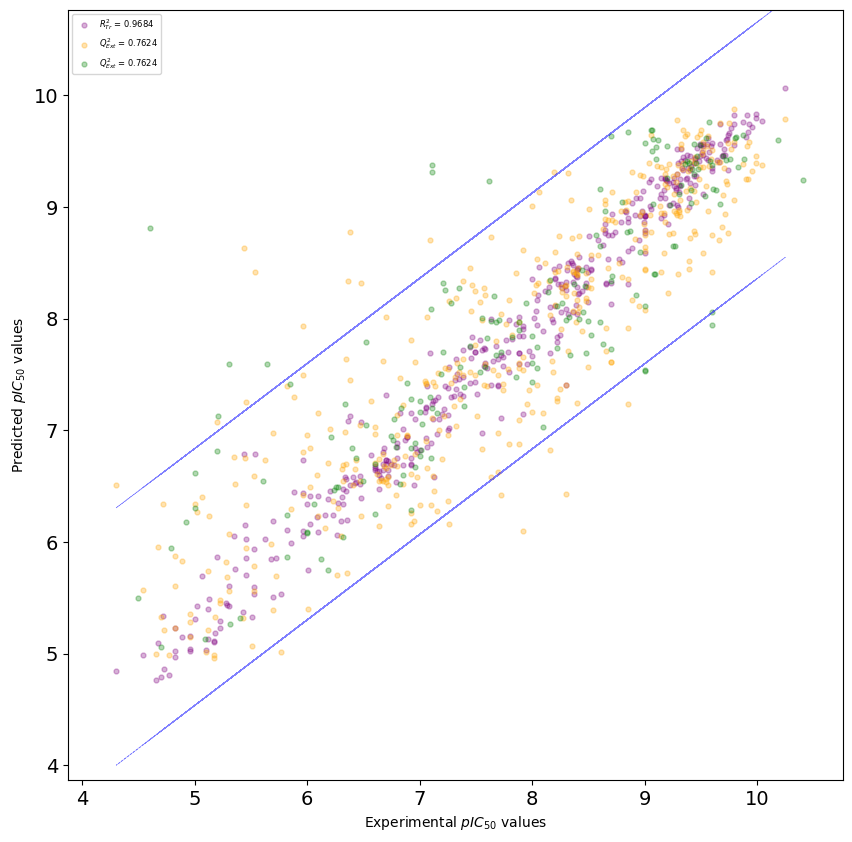

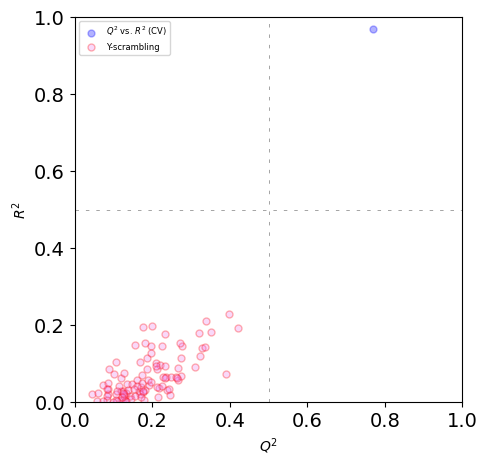

top10 ["['ExtFP612']", "['ExtFP722']", "['ExtFP301']", "['ExtFP1013']", "['ExtFP572']", "['ExtFP279']", "['ExtFP143']", "['ExtFP716']", "['ExtFP84']", "['ExtFP217']"]
top20 ["['ExtFP612']", "['ExtFP722']", "['ExtFP301']", "['ExtFP1013']", "['ExtFP572']", "['ExtFP279']", "['ExtFP143']", "['ExtFP716']", "['ExtFP84']", "['ExtFP217']", "['ExtFP529']", "['ExtFP851']", "['ExtFP903']", "['ExtFP397']", "['ExtFP56']", "['ExtFP866']", "['ExtFP281']", "['ExtFP406']", "['ExtFP384']", "['ExtFP370']"]
top30 ["['ExtFP612']", "['ExtFP722']", "['ExtFP301']", "['ExtFP1013']", "['ExtFP572']", "['ExtFP279']", "['ExtFP143']", "['ExtFP716']", "['ExtFP84']", "['ExtFP217']", "['ExtFP529']", "['ExtFP851']", "['ExtFP903']", "['ExtFP397']", "['ExtFP56']", "['ExtFP866']", "['ExtFP281']", "['ExtFP406']", "['ExtFP384']", "['ExtFP370']", "['ExtFP337']", "['ExtFP99']", "['ExtFP561']", "['ExtFP434']", "['ExtFP801']", "['ExtFP964']", "['ExtFP662']", "['ExtFP220']", "['ExtFP682']", "['ExtFP422']"]
top40 ["['ExtFP612']",

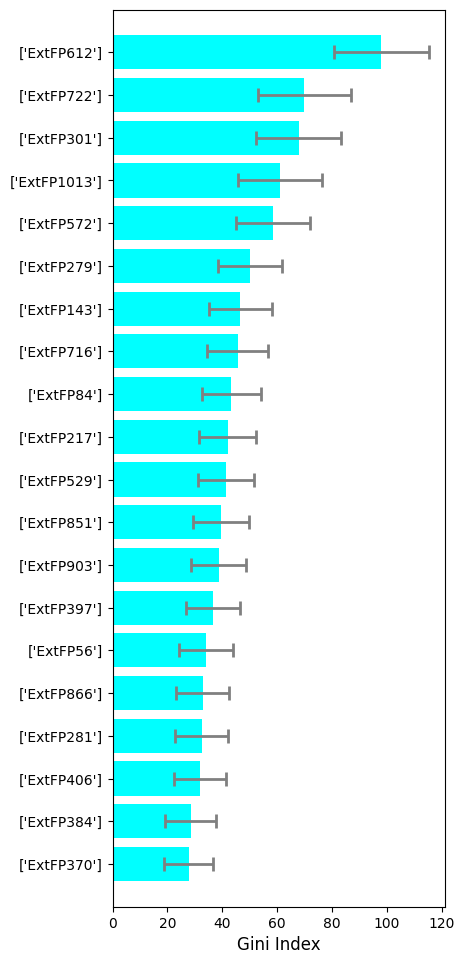

----------------------------------------------------------------------------------------------
KlekotaRoth_nomralized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 4860 descriptors has been reduced to 601 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 601 descriptors has been reduced to 269 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 413      |
+----------------------+----------+
| R2                   | 0.9653   |
+----------------------+----------+
| std_R2               | 0.002241 |
+----------------------+----------+
| RMSE                 | 0.4364   |
+----------------------+----------+
|

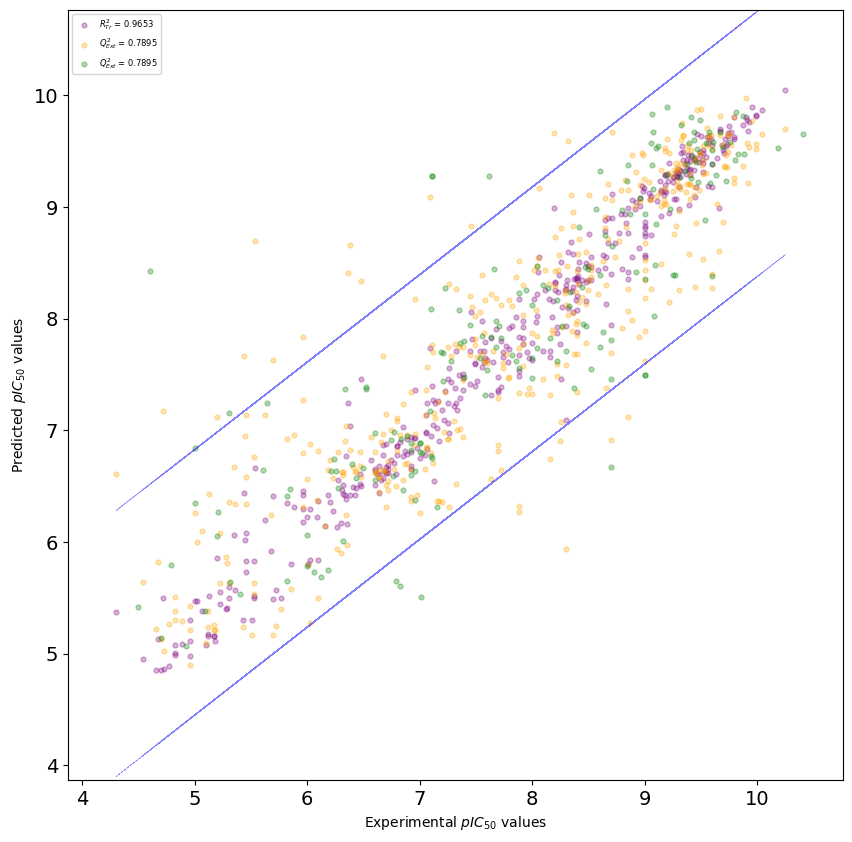

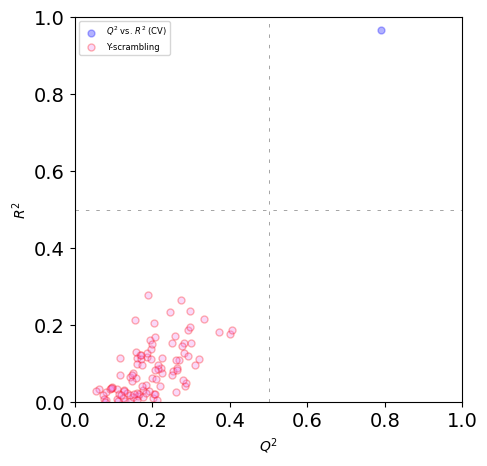

top10 ["['KRFP444']", "['KRFP839']", "['KRFP1148']", "['KRFP1438']", "['KRFP297']", "['KRFP1645']", "['KRFP1642']", "['KRFP3013']", "['KRFP1524']", "['KRFP1591']"]
top20 ["['KRFP444']", "['KRFP839']", "['KRFP1148']", "['KRFP1438']", "['KRFP297']", "['KRFP1645']", "['KRFP1642']", "['KRFP3013']", "['KRFP1524']", "['KRFP1591']", "['KRFP2667']", "['KRFP1156']", "['KRFP1947']", "['KRFP1909']", "['KRFP3943']", "['KRFP2547']", "['KRFP383']", "['KRFP4269']", "['KRFP1154']", "['KRFP3369']"]
top30 ["['KRFP444']", "['KRFP839']", "['KRFP1148']", "['KRFP1438']", "['KRFP297']", "['KRFP1645']", "['KRFP1642']", "['KRFP3013']", "['KRFP1524']", "['KRFP1591']", "['KRFP2667']", "['KRFP1156']", "['KRFP1947']", "['KRFP1909']", "['KRFP3943']", "['KRFP2547']", "['KRFP383']", "['KRFP4269']", "['KRFP1154']", "['KRFP3369']", "['KRFP3956']", "['KRFP1750']", "['KRFP2259']", "['KRFP3224']", "['KRFP2024']", "['KRFP3640']", "['KRFP810']", "['KRFP1013']", "['KRFP3008']", "['KRFP4000']"]
top40 ["['KRFP444']", "['KRFP83

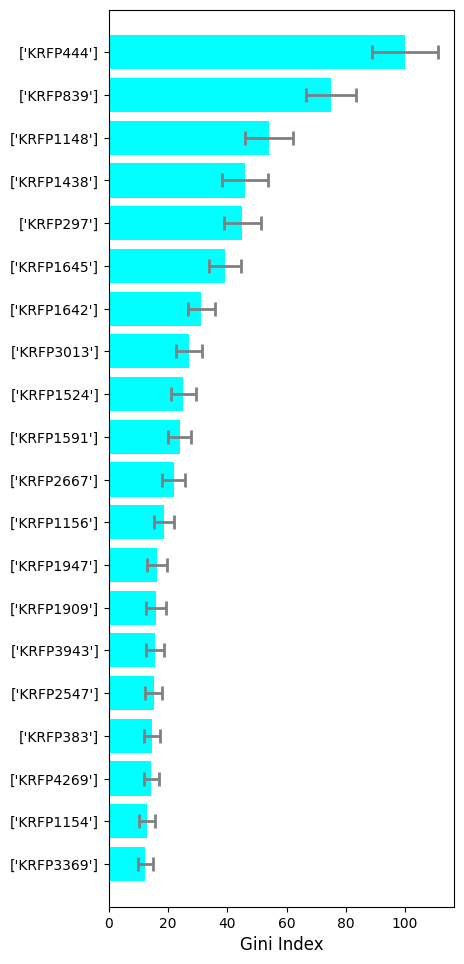

----------------------------------------------------------------------------------------------
KlekotaRothCount_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 4860 descriptors has been reduced to 596 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 596 descriptors has been reduced to 247 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 413      |
+----------------------+----------+
| R2                   | 0.9655   |
+----------------------+----------+
| std_R2               | 0.002084 |
+----------------------+----------+
| RMSE                 | 0.4362   |
+----------------------+--------

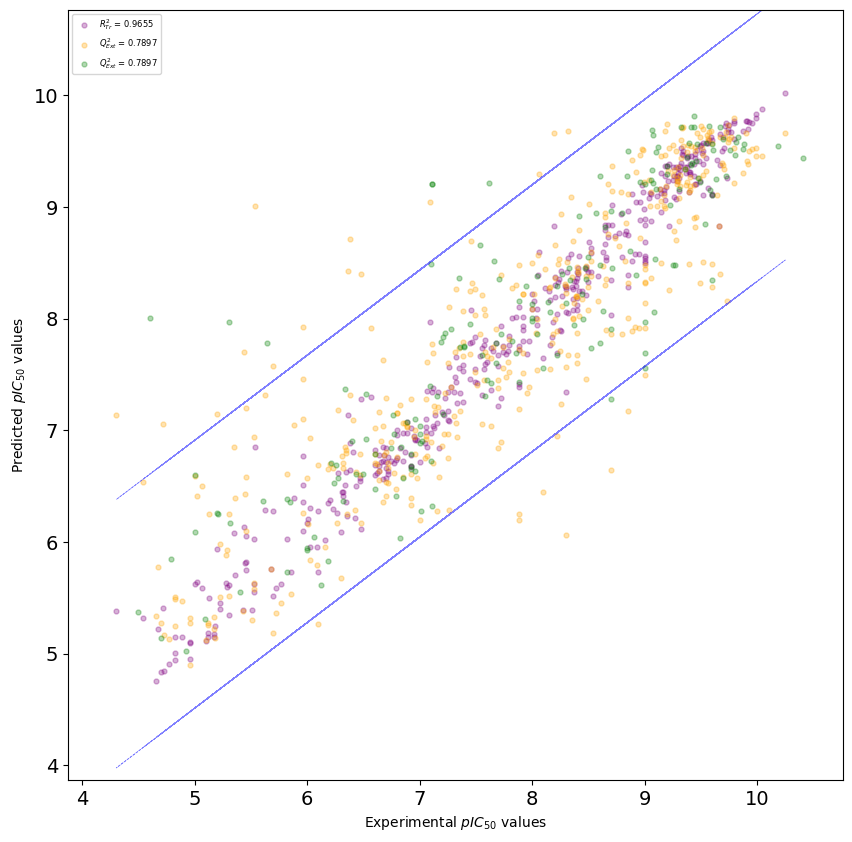

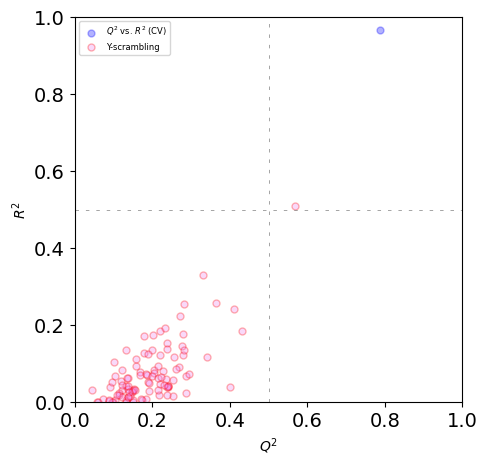

top10 ["['KRFPC297']", "['KRFPC839']", "['KRFPC3574']", "['KRFPC1148']", "['KRFPC1438']", "['KRFPC1645']", "['KRFPC669']", "['KRFPC3013']", "['KRFPC1642']", "['KRFPC677']"]
top20 ["['KRFPC297']", "['KRFPC839']", "['KRFPC3574']", "['KRFPC1148']", "['KRFPC1438']", "['KRFPC1645']", "['KRFPC669']", "['KRFPC3013']", "['KRFPC1642']", "['KRFPC677']", "['KRFPC4331']", "['KRFPC2547']", "['KRFPC1524']", "['KRFPC2667']", "['KRFPC1591']", "['KRFPC1909']", "['KRFPC3943']", "['KRFPC1947']", "['KRFPC1154']", "['KRFPC4269']"]
top30 ["['KRFPC297']", "['KRFPC839']", "['KRFPC3574']", "['KRFPC1148']", "['KRFPC1438']", "['KRFPC1645']", "['KRFPC669']", "['KRFPC3013']", "['KRFPC1642']", "['KRFPC677']", "['KRFPC4331']", "['KRFPC2547']", "['KRFPC1524']", "['KRFPC2667']", "['KRFPC1591']", "['KRFPC1909']", "['KRFPC3943']", "['KRFPC1947']", "['KRFPC1154']", "['KRFPC4269']", "['KRFPC3751']", "['KRFPC2259']", "['KRFPC383']", "['KRFPC3740']", "['KRFPC2986']", "['KRFPC1750']", "['KRFPC2024']", "['KRFPC1564']", "['KRF

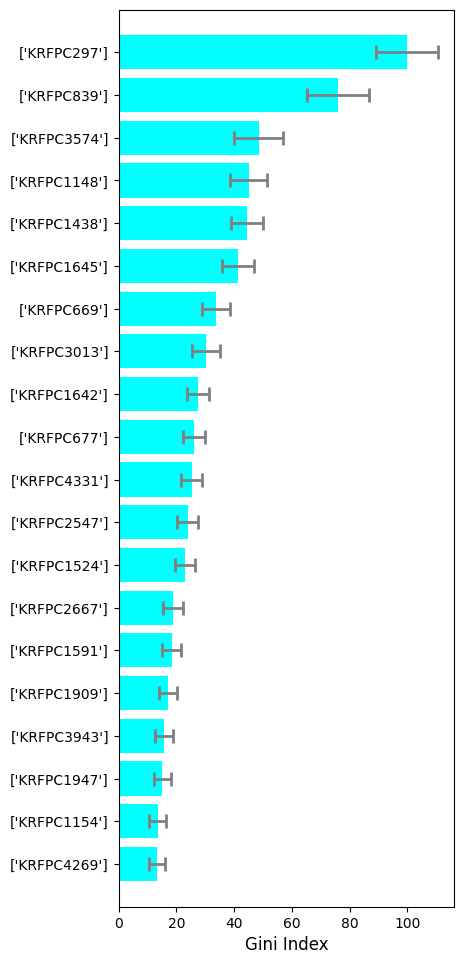

----------------------------------------------------------------------------------------------
Substructure_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 307 descriptors has been reduced to 66 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 66 descriptors has been reduced to 53 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 413      |
+----------------------+----------+
| R2                   | 0.9254   |
+----------------------+----------+
| std_R2               | 0.004960 |
+----------------------+----------+
| RMSE                 | 0.5332   |
+----------------------+----------+
| st

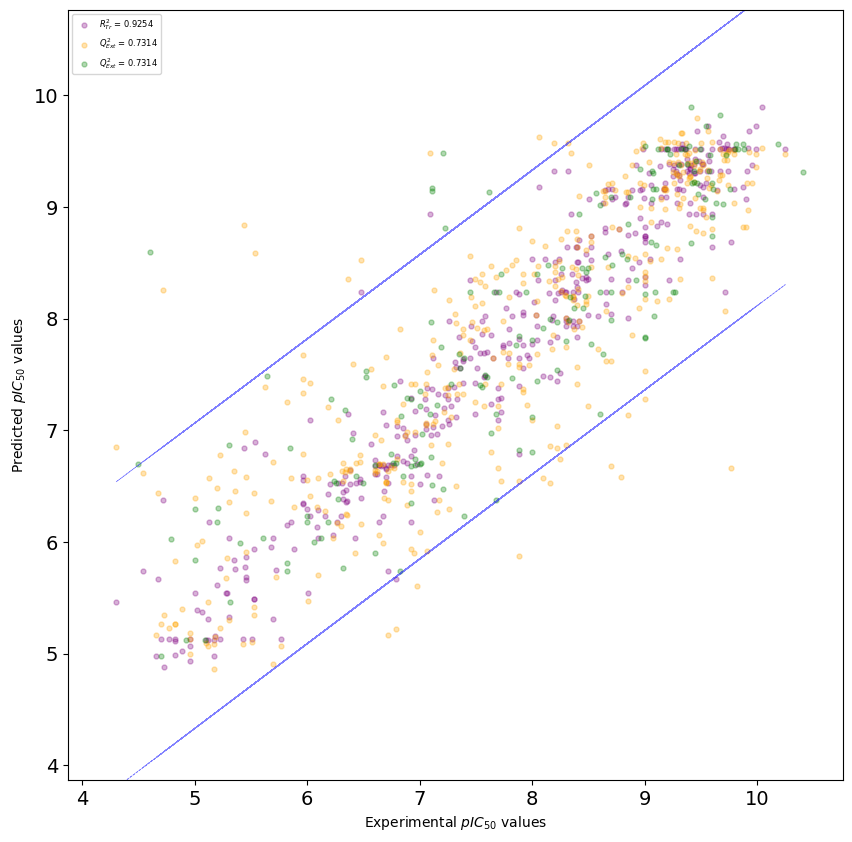

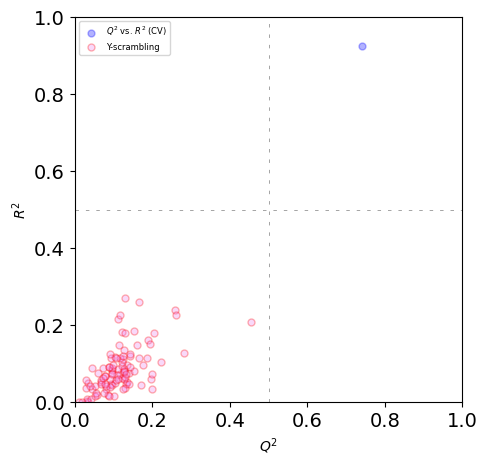

top10 ["['SubFP16']", "['SubFP143']", "['SubFP100']", "['SubFP88']", "['SubFP9']", "['SubFP85']", "['SubFP179']", "['SubFP2']", "['SubFP1']", "['SubFP19']"]
top20 ["['SubFP16']", "['SubFP143']", "['SubFP100']", "['SubFP88']", "['SubFP9']", "['SubFP85']", "['SubFP179']", "['SubFP2']", "['SubFP1']", "['SubFP19']", "['SubFP4']", "['SubFP135']", "['SubFP18']", "['SubFP3']", "['SubFP137']", "['SubFP183']", "['SubFP171']", "['SubFP23']", "['SubFP287']", "['SubFP169']"]
top30 ["['SubFP16']", "['SubFP143']", "['SubFP100']", "['SubFP88']", "['SubFP9']", "['SubFP85']", "['SubFP179']", "['SubFP2']", "['SubFP1']", "['SubFP19']", "['SubFP4']", "['SubFP135']", "['SubFP18']", "['SubFP3']", "['SubFP137']", "['SubFP183']", "['SubFP171']", "['SubFP23']", "['SubFP287']", "['SubFP169']", "['SubFP180']", "['SubFP172']", "['SubFP181']", "['SubFP182']", "['SubFP209']", "['SubFP84']", "['SubFP173']", "['SubFP33']", "['SubFP5']", "['SubFP133']"]
top40 ["['SubFP16']", "['SubFP143']", "['SubFP100']", "['SubFP88'

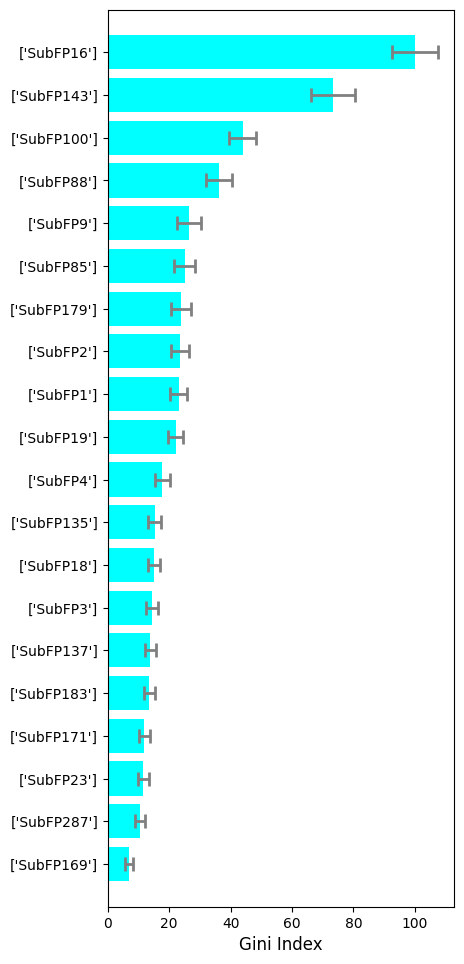

----------------------------------------------------------------------------------------------
SubstrucutreCount_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 307 descriptors has been reduced to 71 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 71 descriptors has been reduced to 54 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 413      |
+----------------------+----------+
| R2                   | 0.9501   |
+----------------------+----------+
| std_R2               | 0.005415 |
+----------------------+----------+
| RMSE                 | 0.4723   |
+----------------------+----------+

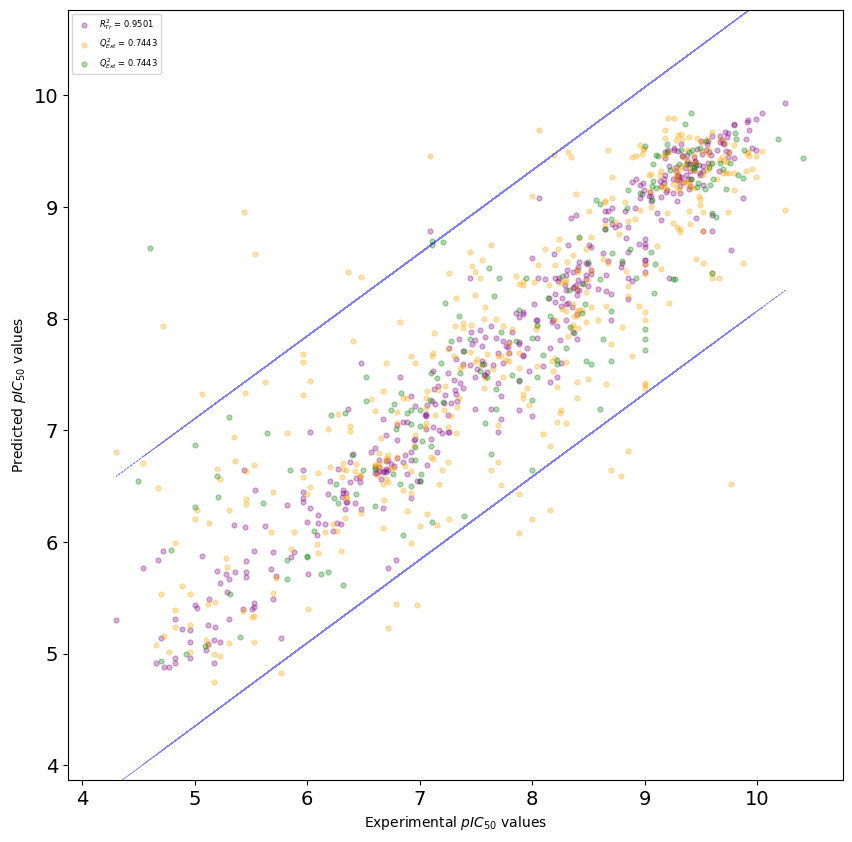

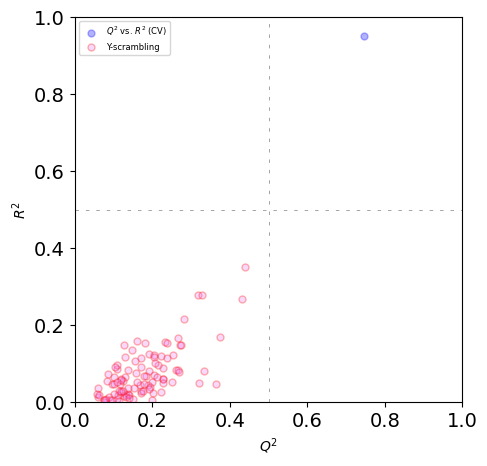

top10 ["['SubFPC16']", "['SubFPC143']", "['SubFPC300']", "['SubFPC137']", "['SubFPC275']", "['SubFPC295']", "['SubFPC302']", "['SubFPC1']", "['SubFPC88']", "['SubFPC100']"]
top20 ["['SubFPC16']", "['SubFPC143']", "['SubFPC300']", "['SubFPC137']", "['SubFPC275']", "['SubFPC295']", "['SubFPC302']", "['SubFPC1']", "['SubFPC88']", "['SubFPC100']", "['SubFPC2']", "['SubFPC85']", "['SubFPC9']", "['SubFPC287']", "['SubFPC181']", "['SubFPC179']", "['SubFPC183']", "['SubFPC19']", "['SubFPC3']", "['SubFPC171']"]
top30 ["['SubFPC16']", "['SubFPC143']", "['SubFPC300']", "['SubFPC137']", "['SubFPC275']", "['SubFPC295']", "['SubFPC302']", "['SubFPC1']", "['SubFPC88']", "['SubFPC100']", "['SubFPC2']", "['SubFPC85']", "['SubFPC9']", "['SubFPC287']", "['SubFPC181']", "['SubFPC179']", "['SubFPC183']", "['SubFPC19']", "['SubFPC3']", "['SubFPC171']", "['SubFPC23']", "['SubFPC135']", "['SubFPC18']", "['SubFPC169']", "['SubFPC172']", "['SubFPC182']", "['SubFPC180']", "['SubFPC173']", "['SubFPC209']", "['Sub

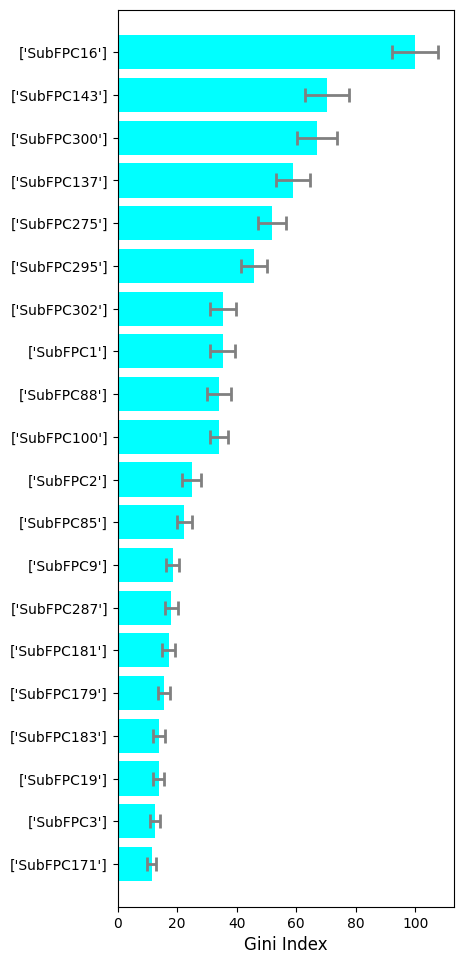

----------------------------------------------------------------------------------------------
MACCS_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 166 descriptors has been reduced to 132 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 132 descriptors has been reduced to 85 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 413      |
+----------------------+----------+
| R2                   | 0.9512   |
+----------------------+----------+
| std_R2               | 0.005561 |
+----------------------+----------+
| RMSE                 | 0.4654   |
+----------------------+----------+
| std_RMS

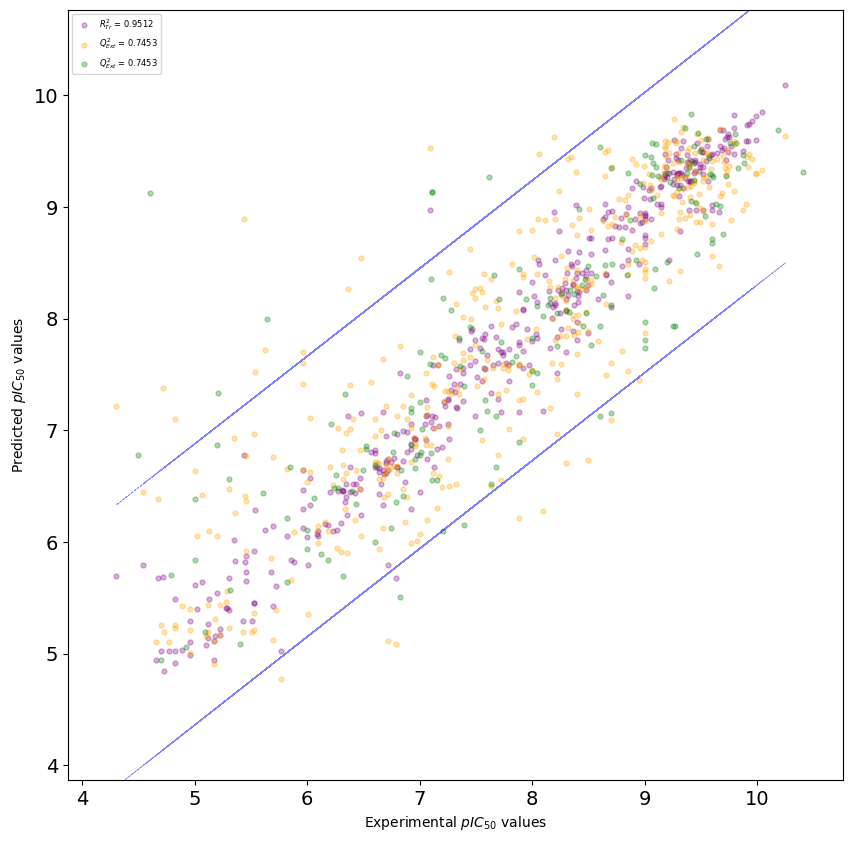

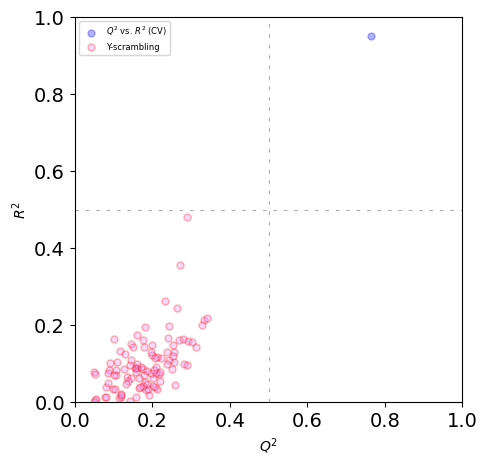

top10 ["['MACCSFP92']", "['MACCSFP86']", "['MACCSFP57']", "['MACCSFP62']", "['MACCSFP37']", "['MACCSFP75']", "['MACCSFP98']", "['MACCSFP111']", "['MACCSFP131']", "['MACCSFP139']"]
top20 ["['MACCSFP92']", "['MACCSFP86']", "['MACCSFP57']", "['MACCSFP62']", "['MACCSFP37']", "['MACCSFP75']", "['MACCSFP98']", "['MACCSFP111']", "['MACCSFP131']", "['MACCSFP139']", "['MACCSFP100']", "['MACCSFP95']", "['MACCSFP105']", "['MACCSFP145']", "['MACCSFP83']", "['MACCSFP113']", "['MACCSFP78']", "['MACCSFP94']", "['MACCSFP42']", "['MACCSFP87']"]
top30 ["['MACCSFP92']", "['MACCSFP86']", "['MACCSFP57']", "['MACCSFP62']", "['MACCSFP37']", "['MACCSFP75']", "['MACCSFP98']", "['MACCSFP111']", "['MACCSFP131']", "['MACCSFP139']", "['MACCSFP100']", "['MACCSFP95']", "['MACCSFP105']", "['MACCSFP145']", "['MACCSFP83']", "['MACCSFP113']", "['MACCSFP78']", "['MACCSFP94']", "['MACCSFP42']", "['MACCSFP87']", "['MACCSFP149']", "['MACCSFP160']", "['MACCSFP150']", "['MACCSFP74']", "['MACCSFP104']", "['MACCSFP144']", "['MA

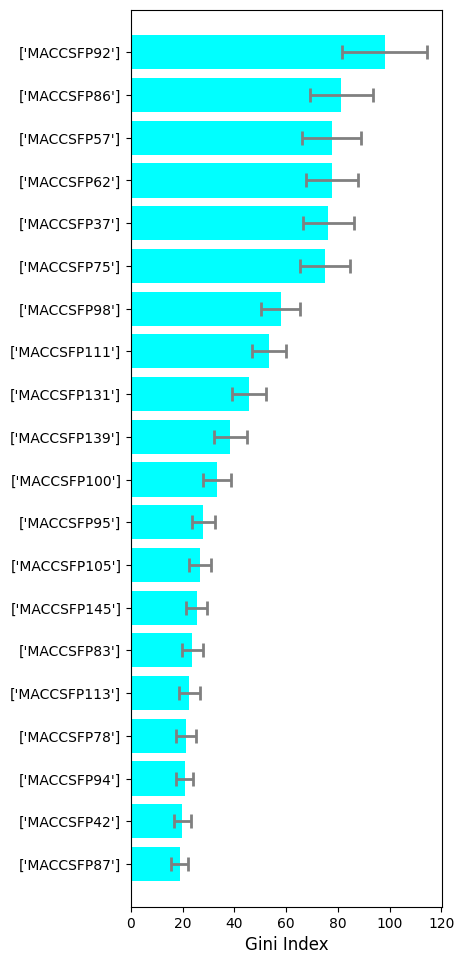

----------------------------------------------------------------------------------------------
PubChem_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 881 descriptors has been reduced to 447 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 447 descriptors has been reduced to 141 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 413      |
+----------------------+----------+
| R2                   | 0.9678   |
+----------------------+----------+
| std_R2               | 0.002158 |
+----------------------+----------+
| RMSE                 | 0.4265   |
+----------------------+----------+
| std_

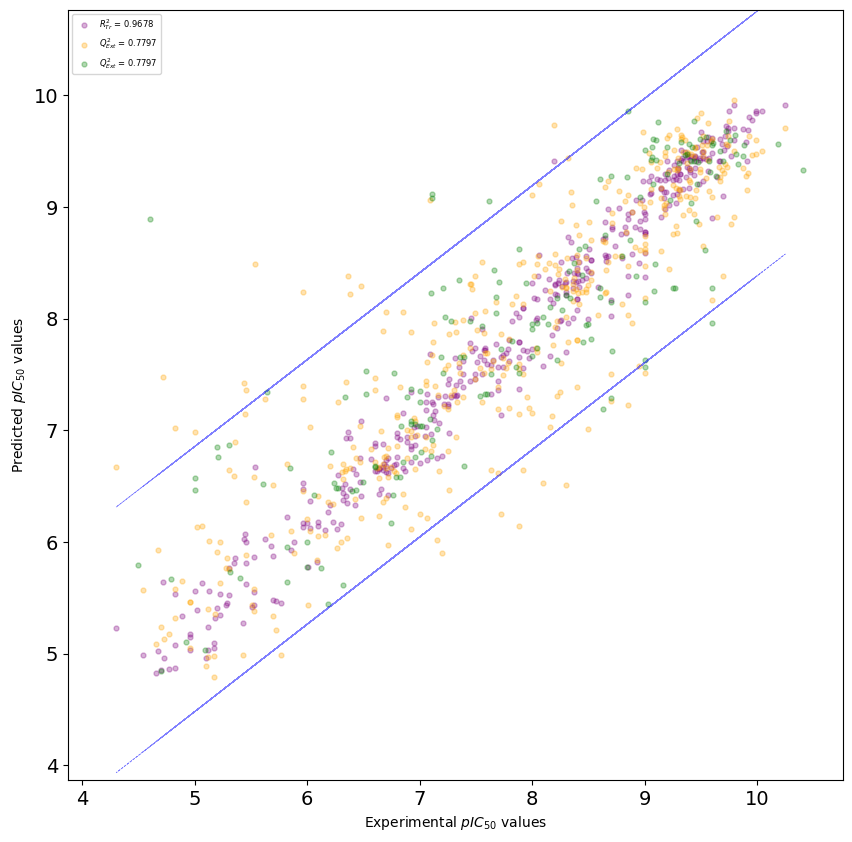

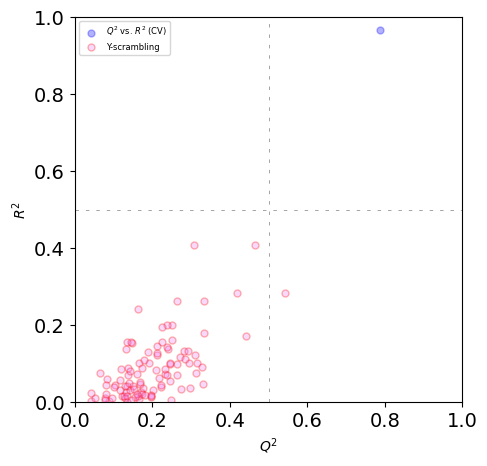

top10 ["['PubchemFP187']", "['PubchemFP439']", "['PubchemFP614']", "['PubchemFP566']", "['PubchemFP180']", "['PubchemFP391']", "['PubchemFP559']", "['PubchemFP734']", "['PubchemFP308']", "['PubchemFP716']"]
top20 ["['PubchemFP187']", "['PubchemFP439']", "['PubchemFP614']", "['PubchemFP566']", "['PubchemFP180']", "['PubchemFP391']", "['PubchemFP559']", "['PubchemFP734']", "['PubchemFP308']", "['PubchemFP716']", "['PubchemFP185']", "['PubchemFP580']", "['PubchemFP143']", "['PubchemFP341']", "['PubchemFP714']", "['PubchemFP528']", "['PubchemFP696']", "['PubchemFP23']", "['PubchemFP334']", "['PubchemFP380']"]
top30 ["['PubchemFP187']", "['PubchemFP439']", "['PubchemFP614']", "['PubchemFP566']", "['PubchemFP180']", "['PubchemFP391']", "['PubchemFP559']", "['PubchemFP734']", "['PubchemFP308']", "['PubchemFP716']", "['PubchemFP185']", "['PubchemFP580']", "['PubchemFP143']", "['PubchemFP341']", "['PubchemFP714']", "['PubchemFP528']", "['PubchemFP696']", "['PubchemFP23']", "['PubchemFP334']", "

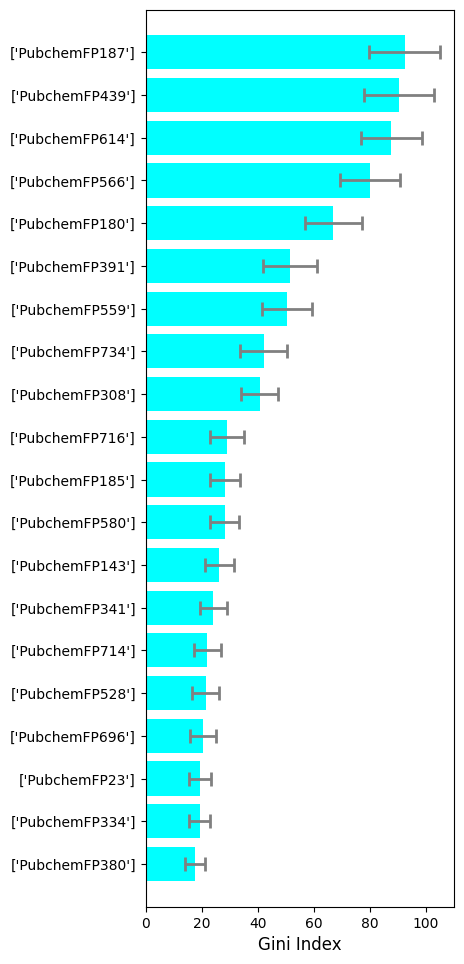

In [24]:
from tabulate import tabulate

SEED = 13

for fp_file in glob.glob(f'{path}*.csv'):
    # Extract the file name without extension
    model_name = extract_file_name(fp_file)
    print("----------------------------------------------------------------------------------------------")
    print(model_name)
    print("---------------------------------------------------")


    df_fp = pd.read_csv(fp_file)
    df_fp = df_fp.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    df_fp = df_fp.fillna(method='ffill')
    data = df_fp.iloc[:, :-1]
    Y = df["pIC50"].values.astype(float)
    data = remove_useless_descriptors(data, 0.05)  # Remove correlation cut off 95%
    data = remove_highly_correlated_descriptors(data, 0.7)  # Remove correlation cut off 0.7


    h = data.columns.tolist()
    hx = np.array(h)

    data = data.values.astype(float)
    X = np.array(data)

    # Prepare empty lists to plot QSAR model
    R2_train = []
    RMSE_train = []
    Q2_cross_val = []
    RMSE_cross_val = []
    Q2_ext = []
    RMSE_ext = []
    prediction_train = []
    importances_dict = defaultdict(list)

    # Prepare empty lists to plot the performance of accuracy.
    r2_scores_train_scrambled= []
    r2_scores_test_scrambled = []



    # Perform model training and validation using the model_name
    for i in range(10):
         Feature, X_train, X_test, y_train, y_test,importances_dict = model_training_and_validation(X, Y, i, hx)

    r2_scores_train_scrambled, r2_scores_test_scrambled =  perform_y_scrambling(X_train, X_test, y_train, y_test)

    R2_train_mean, RMSE_train_mean, Q2_CV_mean, RMSE_CV_mean, Q2_External_mean, RMSE_External_mean, R2_train_std, RMSE_train_std, Q2_CV_std, RMSE_CV_std, Q2_External_std, RMSE_External_std, importances_mean, importances_std = metrics(R2_train, RMSE_train,Q2_cross_val,RMSE_cross_val, Q2_ext,RMSE_ext, importances_dict)

    metrics_table = [
    ['Metric', 'Value'],
    ['Training set', ''],
    ['N', f'{len(X_train)}'],
    ['R2', f'{R2_train_mean:.4f}'],
    ['std_R2', f'{R2_train_std:.6f}'],
    ['RMSE', f'{RMSE_train_mean:.4f}'],
    ['std_RMSE', f'{RMSE_train_std:.6f}'],
    ['', ''],
    ['Cross-validation set', ''],
    ['N', f'{len(X_train)}'],
    ['Q2', f'{Q2_CV_mean:.4f}'],
    ['std_Q2', f'{Q2_CV_std:.6f}'],
    ['RMSE', f'{RMSE_CV_mean:.4f}'],
    ['std_RMSE', f'{RMSE_CV_std:.6f}'],
    ['', ''],
    ['External set', ''],
    ['N', f'{len(X_test)}'],
    ['Q2_EXt', f'{Q2_External_mean:.4f}'],
    ['std_Q2_EXt', f'{Q2_External_std:.6f}'],
    ['RMSE', f'{RMSE_External_mean:.4f}'],
    ['std_RMSE', f'{RMSE_External_std:.6f}']]
    print(tabulate(metrics_table, headers='firstrow', tablefmt='grid'))
    plot_model(fp_file,X_train, X_test, y_train, y_test, R2_train_mean, Q2_External_mean,importances_mean, importances_std, Feature, prediction_train,
                r2_scores_test_scrambled, r2_scores_train_scrambled)